# apillay -> HW4P2: Attention-based Speech Recognition

### WanDB link: https://wandb.ai/audio-idl/hw4p2-ablations?workspace=user-apillay

### Please find the following runs used to track the training for this work:
v3090-66m (https://wandb.ai/audio-idl/hw4p2-ablations/runs/bejv4w15?workspace=user-apillay): Trained model from scratch
v3090-66m-resume (https://wandb.ai/audio-idl/hw4p2-ablations/runs/jvqqfyeq?workspace=user-apillay): Trained from previous model’s last epoch checkpoint with the following changes:
                                                                                                    - Weight Decay changed from 1e-2 to 1e-3
                                                                                                    - Dropout p changed from 0.5 to 0.2
                                                                                                    - Frequency masking factor changed from 3 to 5
                                                                                                    - Time masking probability changed from 0.5 to 0.75
                                                                                                    - Learning rate changed from 2e-4 to 6e-5
                                                                                                    - ReduceLROnPlateau reduction factor changed from 0.75 to 0.8
                                                                                                    - Teacher forcing rate changed from 1.0 to 0.5

### Instructions to run the code: Run all cells in the following sequence!


In [1]:
!nvidia-smi
!nvidia-smi -q -d POWER

Fri May  5 17:21:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:62:00.0 Off |                  N/A |
|  0%   53C    P8    40W / 300W |      6MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Install some required libraries
# Feel free to add more if you want
!pip install -q python-levenshtein torchsummaryX wandb kaggle pytorch-nlp seaborn torchaudio torchinfo

In [ ]:
!sudo apt-get install zip unzip

# Imports

In [2]:
import os
import gc
import torch
from torch import nn
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence, pad_sequence
import torchaudio.transforms as tat
import torchnlp.nn
from torchinfo import summary
import Levenshtein
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

Device:  cuda


# Kaggle Dataset Download

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!rm -rf /root/.kaggle
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"ashwinpillay","key":"<key>"}')
    # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# To download the dataset
!kaggle datasets download -d varunjain3/11-785-s23-hw4p2-dataset

In [ ]:
# To unzip data quickly and quietly
!unzip -q 11-785-s23-hw4p2-dataset.zip -d ./data

# Config

In [3]:
config = {
    'batch_size': 128,
    'lr': 6e-5,
    'tf_rate': 0.5,
    'tf_decay_factor': 0.9,
    'tf_cooldown_period': 15,
    'epochs': 500,
    'max_timesteps': 550,
    'rlrop_params': {
        'factor': 0.8,
        'patience': 4,
        'threshold': 1,
        'threshold_mode': 'rel',
        'cooldown': 2,
    },
    'CA_lr_params': {
        'T_max': 8,
        'eta_min': 1e-6,
    },
    'dropout_p': 0.2,
    'adamw_weight_decay': 1e-3,
    'time_mask_maxl': 50,
    'time_mask_p': 0.75,
    'freq_mask_maxl': 5,
    'num_workers_train': 6,
    'num_workers_val': 4,
    'num_workers_test': 4,
}

# Dataset and Dataloaders

We have given you 2 datasets. One is a toy dataset, and the other is the standard LibriSpeech dataset. The toy dataset is to help you get your code implemented and tested and debugged easily, to verify that your attention diagonal is produced correctly. Note however that it's task (phonetic transcription) is drawn from HW3P2, it is meant to be familiar and help you understand how to transition from phonetic transcription to alphabet transcription, with a working attention module.

Please make sure you use the right constants in your code implementation for future modules, (SOS_TOKEN vs SOS_TOKEN_TOY) when working with either dataset. We have defined the constants accordingly below. Before you come to OH or post on piazza, make sure you aren't misuing the constants for either dataset in your code. 

## LibriSpeech

In terms of the dataset, the dataset structure for HW3P2 and HW4P2 dataset are very similar. Can you spot out the differences? What all will be required?? 

Hints:

- Check how big is the dataset (do you require memory efficient loading techniques??)
- How do we load mfccs? Do we need to normalise them? 
- Does the data have \<SOS> and \<EOS> tokens in each sequences? Do we remove them or do we not remove them? (Read writeup)
- Would we want a collating function? Ask yourself: Why did we need a collate function last time?
- Observe the VOCAB, is the dataset same as HW3P2? 
- Should you add augmentations, if yes which augmentations? When should you add augmentations? (Check bootcamp for answer)


In [4]:
VOCAB = ['<pad>', '<sos>', '<eos>',
         'A',   'B',    'C',    'D',    
         'E',   'F',    'G',    'H',    
         'I',   'J',    'K',    'L',       
         'M',   'N',    'O',    'P',    
         'Q',   'R',    'S',    'T', 
         'U',   'V',    'W',    'X', 
         'Y',   'Z',    "'",    ' ', 
         ]

VOCAB_MAP = {VOCAB[i]:i for i in range(0, len(VOCAB))}

PAD_TOKEN = VOCAB_MAP["<pad>"]
SOS_TOKEN = VOCAB_MAP["<sos>"]
EOS_TOKEN = VOCAB_MAP["<eos>"]

print(f"Length of vocab: {len(VOCAB)}")
print(f"Vocab: {VOCAB}")
print(f"PAD_TOKEN: {PAD_TOKEN}")
print(f"SOS_TOKEN: {SOS_TOKEN}")
print(f"EOS_TOKEN: {EOS_TOKEN}")

Length of vocab: 31
Vocab: ['<pad>', '<sos>', '<eos>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', "'", ' ']
PAD_TOKEN: 0
SOS_TOKEN: 1
EOS_TOKEN: 2


In [5]:
# Utils for network
torch.cuda.empty_cache()


class PermuteBlock(nn.Module):
    def forward(self, x):
        return x.transpose(1, 2)

In [6]:
def cepstral_normalize(mfcc):
    mean_mfcc = np.mean(mfcc, axis=0)
    std_mfcc = np.std(mfcc, axis=0) + np.finfo('float').eps
    normalized_mfcc = (mfcc - mean_mfcc) / std_mfcc
    return normalized_mfcc

In [7]:
class SpeechDatasetTrain(torch.utils.data.Dataset):

    def __init__(self, root1='.', root2=None):
        '''
        Initializes the dataset.
        '''

        self.mfcc_paths, self.transcript_paths = [], []
        self.VOCAB = VOCAB

        self.augmentations = torch.nn.Sequential(
            PermuteBlock(),
            tat.TimeMasking(time_mask_param=config['time_mask_maxl'], p=config['time_mask_p']),
            tat.FrequencyMasking(freq_mask_param=config['freq_mask_maxl']),
            PermuteBlock(),
        )

        roots = [root1]
        if root2 is not None:
            roots.append(root2)

        for root in roots:
            print("=> Loading paths from: {}".format(root))
            mfcc_dir = os.path.join(root, 'mfcc')
            transcript_dir = os.path.join(root, 'transcripts')

            mfcc_files = sorted(os.listdir(mfcc_dir))
            transcript_files = sorted(os.listdir(transcript_dir))

            root_file_length = len(mfcc_files)
            for i in tqdm(range(root_file_length)):
                self.mfcc_paths.append(os.path.join(root, 'mfcc', mfcc_files[i]))
                self.transcript_paths.append(os.path.join(root, 'transcripts', transcript_files[i]))
        # Train Dataset only initializes with path to reduce CPU RAM usage (empirically found that fetching data during __getitem__ is not too costly!

        assert len(self.mfcc_paths) == len(self.transcript_paths)
        self.length = len(self.mfcc_paths)

    def __len__(self):
        return self.length

    def __getitem__(self, ind):
        '''
        Return a tuple of features and labels.
        '''
        return self.mfcc_paths[ind], self.transcript_paths[ind]

    def collate_fn(self, batch):
        '''
        1.  Extract the features and labels from 'batch'
        2.  We will additionally need to pad both features and labels,
            look at pytorch's docs for pad_sequence
        3.  This is a good place to perform transforms, if you so wish.
            Performing them on batches will speed the process up a bit.
        4.  Return batch of features, labels, lenghts of features,
            and lengths of labels.
        '''

        # batch of input mfcc coefficients
        batch_mfcc_paths = [bitem[0] for bitem in batch]

        # batch of output phonemes
        batch_transcript_paths = [bitem[1] for bitem in batch]

        batch_mfcc, batch_transcript = [], []
        for mffc_ind in range(len(batch_mfcc_paths)):
            mfcc = np.load(batch_mfcc_paths[mffc_ind])
            mfcc = cepstral_normalize(mfcc)
            mfcc = torch.FloatTensor(mfcc)
            batch_mfcc.append(mfcc)

            transcript = np.load(batch_transcript_paths[mffc_ind])[1:-1]
            transcript_maps = [self.VOCAB.index(j) for j in transcript]
            transcript = torch.tensor(transcript_maps)
            batch_transcript.append(transcript)

        lengths_mfcc = [len(mfcc_i) for mfcc_i in batch_mfcc]

        lengths_transcript = [len(transcript_i) for transcript_i in batch_transcript]

        batch_mfcc_pad = pad_sequence(batch_mfcc, batch_first=True, padding_value=EOS_TOKEN)
        batch_transcript_pad = pad_sequence(batch_transcript, batch_first=True, padding_value=EOS_TOKEN)

        batch_mfcc_pad = self.augmentations(batch_mfcc_pad)

        # Return the following values: padded features, padded labels, actual length of features, actual length of the labels
        return batch_mfcc_pad, batch_transcript_pad, torch.tensor(lengths_mfcc), torch.tensor(lengths_transcript)

In [8]:
class SpeechDatasetValidate(torch.utils.data.Dataset):

    def __init__(self, root1='.', root2=None):
        '''
        Initializes the dataset.

        '''

        # Load the directory and all files in them

        self.mfccs, self.transcripts = [], []
        self.VOCAB = VOCAB

        roots = [root1]
        if root2 is not None:
            roots.append(root2)

        for root in roots:
            print("=> Loading from: {}".format(root))
            mfcc_dir = os.path.join(root, 'mfcc')
            transcript_dir = os.path.join(root, 'transcripts')

            mfcc_files = sorted(os.listdir(mfcc_dir))
            transcript_files = sorted(os.listdir(transcript_dir))

            root_file_length = len(mfcc_files)
            for i in tqdm(range(root_file_length)):
                mfcc = np.load(os.path.join(root, 'mfcc', mfcc_files[i]))
                mfcc = cepstral_normalize(mfcc)
                self.mfccs.append(mfcc)

                transcript = np.load(os.path.join(root, 'transcripts', transcript_files[i]))[1:-1]
                transcript_maps = [self.VOCAB.index(j) for j in transcript]
                self.transcripts.append(transcript_maps)

        assert len(self.mfccs) == len(self.transcripts)
        self.length = len(self.mfccs)

    def __len__(self):
        return self.length

    def __getitem__(self, ind):
        '''
        Return a tuple of features and labels.
        '''
        mfcc = torch.FloatTensor(self.mfccs[ind])
        transcript = torch.tensor(self.transcripts[ind])
        return mfcc, transcript

    def collate_fn(self, batch):
        '''
        1.  Extract the features and labels from 'batch'
        2.  We will additionally need to pad both features and labels,
            look at pytorch's docs for pad_sequence
        3.  This is a good place to perform transforms, if you so wish.
            Performing them on batches will speed the process up a bit.
        4.  Return batch of features, labels, lenghts of features,
            and lengths of labels.
        '''
        # batch of input mfcc coefficients

        batch_mfcc = [bitem[0] for bitem in batch]

        # batch of output phonemes
        batch_transcript = [bitem[1] for bitem in batch]

        batch_mfcc_pad = pad_sequence(batch_mfcc, batch_first=True, padding_value=EOS_TOKEN)
        lengths_mfcc = [len(mfcc_i) for mfcc_i in batch_mfcc]

        batch_transcript_pad = pad_sequence(batch_transcript, batch_first=True, padding_value=EOS_TOKEN)
        lengths_transcript = [len(transcript_i) for transcript_i in batch_transcript]

        # Return the following values: padded features, padded labels, actual length of features, actual length of the labels
        return batch_mfcc_pad, batch_transcript_pad, torch.tensor(lengths_mfcc), torch.tensor(lengths_transcript)

In [9]:
class SpeechDatasetTest(torch.utils.data.Dataset):

    def __init__(self, root='.'):
        '''
        Initializes the dataset.

        INPUTS: What inputs do you need here?
        '''

        # Load the directory and all files in them

        self.mfcc_dir = os.path.join(root, 'mfcc')

        self.mfcc_files = sorted(os.listdir(self.mfcc_dir))

        self.length = len(self.mfcc_files)

        self.mfccs = []
        for i in tqdm(range(self.length)):
            mfcc = np.load(os.path.join(root, 'mfcc', self.mfcc_files[i]))
            mfcc = cepstral_normalize(mfcc)
            self.mfccs.append(mfcc)

    def __len__(self):
        return self.length

    def __getitem__(self, ind):
        '''
        Return a tuple of features and labels.
        '''

        mfcc = torch.FloatTensor(self.mfccs[ind])
        return mfcc

    def collate_fn(self, batch):
        '''
        1.  Extract the features and labels from 'batch'
        2.  We will additionally need to pad both features and labels,
            look at pytorch's docs for pad_sequence
        3.  This is a good place to perform transforms, if you so wish.
            Performing them on batches will speed the process up a bit.
        4.  Return batch of features, labels, lenghts of features,
            and lengths of labels.
        '''
        # batch of input mfcc coefficients

        batch_mfcc = batch

        batch_mfcc_pad = pad_sequence(batch_mfcc, batch_first=True, padding_value=EOS_TOKEN)
        lengths_mfcc = [len(mfcc_i) for mfcc_i in batch_mfcc]

        # Return the following values: padded features, actual length of features
        return batch_mfcc_pad, torch.tensor(lengths_mfcc)

In [10]:
gc.collect()

# Create objects for the dataset class
print("Loading Train Dataset: ")
train_data = SpeechDatasetTrain(root1='./data/train-clean-100')

print("Loading Val Dataset: ")
val_data = SpeechDatasetValidate(root1='./data/dev-clean')

print("Loading Test Dataset: ")
test_data = SpeechDatasetTest(root='./data/test-clean')

# Do NOT forget to pass in the collate function as parameter while creating the dataloader
train_loader = torch.utils.data.DataLoader(
    dataset=train_data,
    collate_fn=train_data.collate_fn,
    num_workers=config['num_workers_train'],
    batch_size=config['batch_size'],
    pin_memory=True,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_data,
    collate_fn=val_data.collate_fn,
    num_workers=config['num_workers_val'],
    batch_size=config['batch_size'],
    pin_memory=True,
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_data,
    collate_fn=test_data.collate_fn,
    num_workers=config['num_workers_test'],
    batch_size=config['batch_size'],
    pin_memory=True,
    shuffle=False
)

print("\nBatch size: ", config['batch_size'])
print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Val dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

Loading Train Dataset: 
=> Loading paths from: ./data/train-clean-100


100%|██████████| 28539/28539 [00:00<00:00, 275852.53it/s]


Loading Val Dataset: 
=> Loading from: ./data/dev-clean


100%|██████████| 2703/2703 [00:01<00:00, 1643.98it/s]


Loading Test Dataset: 


100%|██████████| 2620/2620 [00:00<00:00, 2855.96it/s]


Batch size:  128
Train dataset samples = 28539, batches = 223
Val dataset samples = 2703, batches = 22
Test dataset samples = 2620, batches = 21


In [11]:
gc.collect()
torch.cuda.empty_cache()

torch.Size([128, 1634, 27]) torch.Size([128, 300]) torch.Size([128]) torch.Size([128])


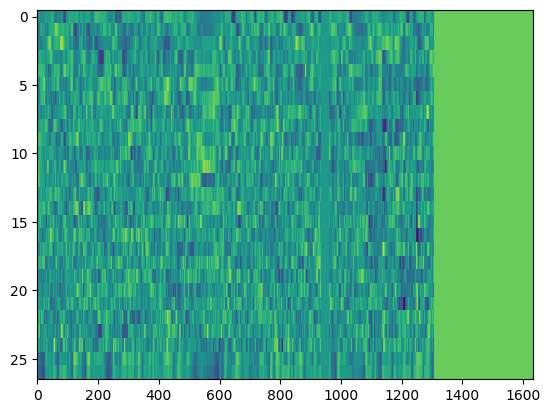

In [12]:
for data in train_loader:
    x, y, lx, ly = data
    print(x.shape, y.shape, lx.shape, ly.shape)
    # Plots train data with its augmentations
    plt.imshow(x[0].T, interpolation='nearest', aspect='auto', cmap='viridis')
    plt.show()
    break

# THE MODEL

### Listen, Attend and Spell
Listen, Attend and Spell (LAS) is a neural network model used for speech recognition and synthesis tasks.

- LAS is designed to handle long input sequences and is robust to noisy speech signals.
- LAS is known for its high accuracy and ability to improve over time with additional training data.
- It consists of an <b>listener, an attender and a speller</b>, which work together to convert an input speech signal into a corresponding output text.

#### The Listener:
- converts the input speech signal into a sequence of hidden states.

#### The Attender:
- Decides how the sequence of Encoder hidden state is propogated to decoder.

#### The Speller:
- A language model, that incorporates the "context of attender"(output of attender) to predict sequence of words.






## The Listener:
### Borrowed Liberally from the encoder of my HW3P2 submission

In [13]:
class Resnet34ResidualBlock1d(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, kernel_size=3, padding=1):
        super(Resnet34ResidualBlock1d, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(True)
        )
        self.cnn2 = nn.Sequential(
            nn.Conv1d(out_channels, out_channels, kernel_size, 1, padding, bias=False),
            nn.BatchNorm1d(out_channels)
        )
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )
        else:
            self.shortcut = nn.Sequential()

    def forward(self, x):
        residual = x
        x = self.cnn1(x)
        x = self.cnn2(x)
        x += self.shortcut(residual)
        x = nn.ReLU(True)(x)
        return x

In [14]:
class pBLSTM(nn.Module):
    '''
    Pyramidal BiLSTM
    Read the writeup/paper and understand the concepts and then write your implementation here.

    At each step,
    1. Pad your input if it is packed (Unpack it)
    2. Reduce the input length dimension by concatenating feature dimension
        (Tip: Write down the shapes and understand)
        (i) How should  you deal with odd/even length input?
        (ii) How should you deal with input length array (x_lens) after truncating the input?
    3. Pack your input
    4. Pass it into LSTM layer

    To make our implementation modular, we pass 1 layer at a time.
    '''

    def __init__(self, input_size, hidden_size, n_lstm=1):
        super(pBLSTM, self).__init__()

        self.ld = torchnlp.nn.LockedDropout(p=config['dropout_p'])

        self.ln = nn.LayerNorm(input_size * 2, eps=1e-06)

        self.blstm = nn.LSTM(input_size=input_size * 2, hidden_size=hidden_size, num_layers=n_lstm, bidirectional=True,
                             batch_first=True)

    def forward(self, x_packed):  # x_packed is a PackedSequence

        # Pad Packed Sequence
        x, x_lens = pad_packed_sequence(x_packed, batch_first=True, padding_value=0.0)

        x, x_lens = self.trunc_reshape(x, x_lens)

        x = torch.permute(x, (1, 0, 2))
        x = self.ld(x)
        x = self.ln(x)
        x = torch.permute(x, (1, 0, 2))

        # Pack Padded Sequence.
        x = pack_padded_sequence(x, lengths=x_lens, batch_first=True, enforce_sorted=False)

        # Pass the sequence through bLSTM
        x, _ = self.blstm(x)

        return x

    def trunc_reshape(self, x, x_lens):
        if x.size(dim=1) % 2 == 1:
            x = x[:, :-1, :]
        x = x.reshape(x.shape[0], x.shape[1] // 2, x.shape[2] * 2)
        x_lens //= 2
        return x, x_lens

In [15]:
class Listener(nn.Module):
    '''
    The Encoder takes utterances as inputs and returns latent feature representations
    '''

    def __init__(self, input_feature_size=27, encoder_hidden_size=256):
        super(Listener, self).__init__()

        self.embedding_stride = 1
        self.embedding_kernel_size = 3
        self.embedding_padding = 1

        self.embedding = nn.Sequential(
            PermuteBlock(),
            Resnet34ResidualBlock1d(in_channels=input_feature_size, out_channels=1024, stride=self.embedding_stride,
                                    kernel_size=self.embedding_kernel_size, padding=self.embedding_padding),
            PermuteBlock(),
        )

        self.pBLSTMs = nn.Sequential(
            pBLSTM(input_size=1024, hidden_size=encoder_hidden_size, n_lstm=2),
            pBLSTM(input_size=encoder_hidden_size * 2, hidden_size=encoder_hidden_size, n_lstm=2),
        )

    def forward(self, x, x_lens):
        # Call the embedding layer
        x = self.embedding(x)
        # x_lens = (x_lens - self.embedding_kernel_size + 2 * self.embedding_padding) // self.embedding_stride

        # Pack Padded Sequence
        x = pack_padded_sequence(x, lengths=x_lens, batch_first=True, enforce_sorted=False)

        # Pass Sequence through the pyramidal Bi-LSTM layer
        x = self.pBLSTMs(x)

        # Pad Packed Sequence
        encoder_outputs, encoder_lens = pad_packed_sequence(x, batch_first=True, padding_value=0.0)

        return encoder_outputs, encoder_lens

## Attention

In [16]:
# Dot Product Attention:
class Attention(nn.Module):
    '''
    Attention is calculated using the key, value (from encoder embeddings) and query from decoder.

    After obtaining the raw weights, compute and return attention weights and context as follows.:

    attention_weights   = softmax(raw_weights)
    attention_context   = einsum("thinkwhatwouldbetheequationhere",attention, value) #take hint from raw_weights calculation

    At the end, you can pass context through a linear layer too.
    '''

    def __init__(self, encoder_hidden_size, decoder_hidden_size, projection_size):
        super(Attention, self).__init__()
        self.VW = nn.Linear(in_features=encoder_hidden_size * 2, out_features=projection_size)
        self.KW = nn.Linear(in_features=encoder_hidden_size * 2, out_features=projection_size)
        self.QW = nn.Linear(in_features=decoder_hidden_size, out_features=projection_size)

    def set_key_value(self, encoder_outputs):
        '''
        In this function we take the encoder embeddings and make key and values from it.
        key.shape   = (batch_size, timesteps, projection_size)
        value.shape = (batch_size, timesteps, projection_size)
        '''
        self.key = self.KW(encoder_outputs)
        self.value = self.VW(encoder_outputs)

    def compute_context(self, decoder_context):
        '''
        In this function from decoder context, we make the query, and then we
         multiply the queries with the keys to find the attention logits,
         finally we take a softmax to calculate attention energy which gets
         multiplied to the generted values and then gets summed.

        key.shape   = (batch_size, timesteps, projection_size) -> (B, P, T)
        value.shape = (batch_size, timesteps, projection_size)
        query.shape = (batch_size, 1, projection_size) -> (B, 1, P)

        You are also recomended to check out Abu's Lecture 19 to understand Attention better.
        '''

        query = self.QW(decoder_context)  # (batch_size, 1, projection_size)

        # Using bmm or einsum. We need to perform batch matrix multiplication. It is important you do this step correctly.
        # What will be the shape of raw_weights?
        raw_weights = torch.bmm(query, self.key.mT) / (query.shape[1] ** 0.5)  # (B, 1, T)

        # Raw_weights -> attention_weights
        attention_weights = nn.functional.softmax(raw_weights, dim=2)  # over dim=T

        # Multiply attention weights to values
        attention_context = torch.bmm(attention_weights, self.value)

        return attention_context, attention_weights

## The Speller

Similar to the language model that you coded up for HW4P1, you have to code a language model for HW4P2 as well. This time, we will also call theattention context step, within the decoder to get the attended-encoder-embeddings.


In [17]:
# Derived from: https://pytorchnlp.readthedocs.io/en/latest/_modules/torchnlp/nn/lock_dropout.html
class LockedDropoutCell(nn.Module):
    def __init__(self, p=0.5):
        self.p = p
        super().__init__()
        self.mask = None

    def create_mask(self, x):
        mask = x.new_empty(x.size(0), x.size(1), requires_grad=False).bernoulli_(1 - self.p)
        mask = mask.div_(1 - self.p)
        self.mask = mask.expand_as(x)

    def delete_mask(self):
        self.mask = None

    def forward(self, x):
        if not self.training or not self.p:
            return x

        if self.mask is None:
            self.create_mask(x.clone())
        return x * self.mask

In [18]:
class Speller(torch.nn.Module):

    def __init__(self, attender: Attention, vocab_size, encoder_hidden_size, decoder_embedding_size=256,
                 attention_projection_size=128, decoder_hidden_size=256, max_timesteps=550):
        super().__init__()

        self.encoder_hidden_size = encoder_hidden_size

        self.max_timesteps = max_timesteps

        self.attend = attender  # Attention object in speller

        # Embedding layer to convert token to latent space
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=decoder_embedding_size)

        # Sequence of LSTM Cells
        self.lstm_cells = nn.Sequential(
            nn.LSTMCell(input_size=decoder_embedding_size + attention_projection_size, hidden_size=decoder_hidden_size),
            nn.LSTMCell(input_size=decoder_hidden_size, hidden_size=decoder_hidden_size),
            nn.LSTMCell(input_size=decoder_hidden_size, hidden_size=decoder_hidden_size),
            nn.LSTMCell(input_size=decoder_hidden_size, hidden_size=decoder_hidden_size),
        )

        self.lds = nn.Sequential(
            LockedDropoutCell(p=config['dropout_p']),
            LockedDropoutCell(p=config['dropout_p']),
            LockedDropoutCell(p=config['dropout_p']),
            LockedDropoutCell(p=config['dropout_p'])
        )

        # For CDN (Feel free to change)

        # Linear module to convert outputs to correct hidden size
        # + Linear layer to convert hidden space back to logits for token classification
        self.char_prob = nn.Sequential(
            nn.Linear(in_features=(decoder_hidden_size + attention_projection_size),
                      out_features=decoder_embedding_size),
            nn.GELU(),
            nn.Linear(in_features=decoder_embedding_size, out_features=vocab_size))

        # Weight tying (From embedding layer)
        self.char_prob[2].weight = self.embedding.weight
        self.attention_projection_size = attention_projection_size

    def lstm_step(self, input_word, hidden_state):
        for i in range(len(self.lstm_cells)):
            # Forward pass through each LSTMCell
            hidden_state[i] = self.lstm_cells[i](input_word, hidden_state[i])
            input_word = hidden_state[i][0]
            input_word = self.lds[i](input_word)  # Keeps last lstm cell's output over that timestep
        return input_word, hidden_state

    def forward(self, batch_size, y=None, teacher_forcing_ratio=1):
        # initial context tensor for time t = 0
        attn_context = torch.zeros((batch_size, self.attention_projection_size)).to(DEVICE)

        output_symbol = torch.zeros((batch_size,)).long().to(DEVICE)
        output_symbol[:, ] = SOS_TOKEN  # Set it to SOS for time t = 0

        raw_outputs = []
        attention_plot = []

        if y is None:
            timesteps = self.max_timesteps
            teacher_forcing_ratio = 0  # Why does it become zero?
        else:
            # Timesteps we are predicting for
            timesteps = y.shape[1]

        # Initializing hidden_states list
        hidden_states_list = [None] * len(self.lstm_cells)

        for ld in self.lds:
            ld.delete_mask()

        for t in range(timesteps):
            p = np.random.random()  # generate a probability p between 0 and 1

            # Take from y, else draw from probability distribution
            if p < teacher_forcing_ratio and t > 0:
                output_symbol = y[:, t - 1]

            # Embed the character symbol
            char_embed = self.embedding(output_symbol.long())

            # Concatenate the character embedding and context from attention, as shown in the diagram
            lstm_input = torch.concatenate((char_embed, attn_context), dim=1)

            # Feed the input through LSTM Cells and attention.
            rnn_out, hidden_states_list = self.lstm_step(lstm_input, hidden_states_list)

            # Feed the resulting hidden state into attention
            attn_context, attn_weights = self.attend.compute_context(rnn_out.unsqueeze(dim=1))
            attn_context = attn_context.squeeze(dim=1)

            # Concatenating the context from the attention module with the LSTM output hidden state
            cdn_input = torch.concatenate((rnn_out, attn_context), dim=1)

            # Calling CDN with cdn_input
            raw_pred = self.char_prob(cdn_input.squeeze(dim=1))

            # Generate a prediction for this timestep and collect it in output_symbols
            output_symbol = torch.argmax(raw_pred, dim=1)

            raw_outputs.append(raw_pred)  # for loss calculation
            attention_plot.append(attn_weights)  # for plotting attention plot

        attention_plot = torch.stack(attention_plot, dim=1)
        raw_outputs = torch.stack(raw_outputs, dim=1)

        return raw_outputs, attention_plot

## LAS

Here we finally build the LAS model, comibining the listener, attender and speller together, we have given a template, but you are free to read the paper and implement it yourself.

In [19]:
class LAS(torch.nn.Module):
    def __init__(self, vocab_size, encoder_hidden_size, decoder_hidden_size, decoder_embedding_size,
                 attention_projection_size,
                 max_timesteps):  # add parameters
        super().__init__()

        # Pass the right parameters here
        self.listener = Listener(input_feature_size=27,
                                 encoder_hidden_size=encoder_hidden_size)
        self.attend = Attention(encoder_hidden_size=encoder_hidden_size,
                                decoder_hidden_size=decoder_hidden_size,
                                projection_size=attention_projection_size)
        self.speller = Speller(attender=self.attend,
                               vocab_size=vocab_size,
                               encoder_hidden_size=encoder_hidden_size,
                               decoder_embedding_size=decoder_embedding_size,
                               attention_projection_size=attention_projection_size,
                               decoder_hidden_size=decoder_hidden_size,
                               max_timesteps=max_timesteps)

    def forward(self, x, lx, y=None, teacher_forcing_ratio=1):
        # Encode speech features
        encoder_outputs, _ = self.listener(x, lx)

        # We want to compute keys and values ahead of the decoding step, as they are constant for all timesteps
        # Set keys and values using the encoder outputs
        self.attend.set_key_value(encoder_outputs)

        # Decode text with the speller using context from the attention
        raw_outputs, attention_plots = self.speller(batch_size=x.shape[0], y=y, teacher_forcing_ratio=teacher_forcing_ratio)

        return raw_outputs, attention_plots

# Model Setup 

In [20]:
model = LAS(
    vocab_size=len(VOCAB),
    encoder_hidden_size=640,
    decoder_hidden_size=512,
    decoder_embedding_size=512,
    attention_projection_size=512,
    max_timesteps=config['max_timesteps']
)

model = model.to(DEVICE)
print(model)

x = x.float().to(DEVICE)
y = y.to(DEVICE)

summary(model)

LAS(
  (listener): Listener(
    (embedding): Sequential(
      (0): PermuteBlock()
      (1): Resnet34ResidualBlock1d(
        (cnn1): Sequential(
          (0): Conv1d(27, 1024, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (cnn2): Sequential(
          (0): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (shortcut): Sequential(
          (0): Conv1d(27, 1024, kernel_size=(1,), stride=(1,), bias=False)
          (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): PermuteBlock()
    )
    (pBLSTMs): Sequential(
      (0): pBLSTM(
        (ld): LockedDropout(p=0.2)
        (ln): LayerNorm((2048,), eps=1e-06, elementwise_affin

Layer (type:depth-idx)                        Param #
LAS                                           --
├─Listener: 1-1                               --
│    └─Sequential: 2-1                        --
│    │    └─PermuteBlock: 3-1                 --
│    │    └─Resnet34ResidualBlock1d: 3-2      3,262,464
│    │    └─PermuteBlock: 3-3                 --
│    └─Sequential: 2-2                        --
│    │    └─pBLSTM: 3-4                       23,617,536
│    │    └─pBLSTM: 3-5                       26,240,000
├─Attention: 1-2                              --
│    └─Linear: 2-3                            655,872
│    └─Linear: 2-4                            655,872
│    └─Linear: 2-5                            262,656
├─Speller: 1-3                                1,558,528
│    └─Attention: 2-6                         (recursive)
│    │    └─Linear: 3-6                       (recursive)
│    │    └─Linear: 3-7                       (recursive)
│    │    └─Linear: 3-8                  

# Loss Function, Optimizers, Scheduler

In [21]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config['adamw_weight_decay'])

criterion = torch.nn.CrossEntropyLoss(reduction='mean', ignore_index=PAD_TOKEN)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, **config['rlrop_params'])

scaler = torch.cuda.amp.GradScaler()

# Levenshtein Distance

In [22]:
# We have given you this utility function which takes a sequence of indices and converts them to a list of characters
def indices_to_chars(indices, vocab):
    tokens = []
    for i in indices: # This loops through all the indices
        if int(i) == SOS_TOKEN: # If SOS is encountered, dont add it to the final list
            continue
        elif int(i) == EOS_TOKEN: # If EOS is encountered, stop the decoding process
            break
        else:
            tokens.append(vocab[int(i)])
    return tokens

# To make your life more easier, we have given the Levenshtein distantce / Edit distance calculation code
def calc_edit_distance(predictions, y, ly, vocab= VOCAB, print_example= False):

    dist                = 0
    batch_size, seq_len = predictions.shape

    for batch_idx in range(batch_size): 

        y_sliced    = indices_to_chars(y[batch_idx,0:ly[batch_idx]], vocab)
        pred_sliced = indices_to_chars(predictions[batch_idx], vocab)

        # Strings - When you are using characters from the AudioDataset
        y_string    = ''.join(y_sliced)
        pred_string = ''.join(pred_sliced)
        
        dist        += Levenshtein.distance(pred_string, y_string)
        # Comment the above and uncomment below for toy dataset, as the toy dataset has a list of phonemes to compare
        # dist      += Levenshtein.distance(y_sliced, pred_sliced)

    if print_example: 
        # Print y_sliced and pred_sliced if you are using the toy dataset
        print("Ground Truth : ", y_string)
        print("Prediction   : ", pred_string)
        
    dist/=batch_size
    return dist

# Train and Validation functions 


In [23]:
def train(model, dataloader, criterion, optimizer, teacher_forcing_rate):
    model.train()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    running_loss = 0.0
    running_perplexity = 0.0

    for i, (x, y, lx, ly) in enumerate(dataloader):
        optimizer.zero_grad()

        x, y = x.to(DEVICE), y.to(DEVICE)

        with torch.cuda.amp.autocast():
            raw_predictions, attention_plot = model(x, lx, y=y, teacher_forcing_ratio=teacher_forcing_rate)

            outs = raw_predictions.reshape(-1, raw_predictions.shape[-1])
            y = y.reshape(-1).long()
            loss = criterion(outs, y)

            perplexity = torch.exp(loss)  # Perplexity is defined the exponential of the loss

            running_loss += loss.item()
            running_perplexity += perplexity.item()

        # Backward on the masked loss
        scaler.scale(loss).backward()

        scaler.step(optimizer)
        scaler.update()

        batch_bar.set_postfix(
            loss="{:.04f}".format(running_loss / (i + 1)),
            perplexity="{:.04f}".format(running_perplexity / (i + 1)),
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])),
            tf_rate='{:.02f}'.format(teacher_forcing_rate))
        batch_bar.update()

        del x, y, lx, ly, outs, raw_predictions
        torch.cuda.empty_cache()

    running_loss /= len(dataloader)
    running_perplexity /= len(dataloader)
    batch_bar.close()

    return running_loss, running_perplexity, attention_plot

In [24]:
def validate(model, dataloader):
    model.eval()

    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc="Val")

    running_lev_dist = 0.0
    for i, (x, y, lx, ly) in enumerate(dataloader):
        x, y, lx, ly = x.to(DEVICE), y.to(DEVICE), lx, ly

        with torch.inference_mode():
            raw_predictions, _ = model(x, lx, y=None)

        # Greedy Decoding
        # Get the most likely character from each distribution in the batch
        greedy_predictions = torch.argmax(raw_predictions, dim=2)

        # Calculate Levenshtein Distance
        if i == len(dataloader) - 1:
            running_lev_dist += calc_edit_distance(greedy_predictions, y, ly, VOCAB, print_example=True)
        else:   
            running_lev_dist += calc_edit_distance(greedy_predictions, y, ly, VOCAB, print_example=False)

        batch_bar.set_postfix(
            dist="{:.04f}".format(running_lev_dist / (i + 1)))
        batch_bar.update()

        del x, y, lx, ly, raw_predictions, greedy_predictions
        torch.cuda.empty_cache()

    batch_bar.close()
    running_lev_dist /= len(dataloader)

    return running_lev_dist

# Experiment

In [25]:
import wandb

wandb.login(key="<key>")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: apillay (audio-idl). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [26]:
run = wandb.init(
    name="v3090-66m-resume",  ## Wandb creates random run names if you skip this field
    reinit=True,  ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project="hw4p2-ablations",  ### Project should be created in your wandb account
    config=config  ### Wandb Config for your run
)

In [27]:
def save_model(model, optimizer, scheduler, metric, epoch, path):
    torch.save(
        {'model_state_dict': model.state_dict(),
         'optimizer_state_dict': optimizer.state_dict(),
         'scheduler_state_dict': scheduler.state_dict(),
         metric[0]: metric[1],
         'epoch': epoch},
        path
    )


def load_model(path, model, metric='val_ld', optimizer=None, scheduler=None):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])

    if optimizer != None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if scheduler != None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    epoch = checkpoint['epoch']
    metric = checkpoint[metric]

    return [model, optimizer, scheduler, epoch, metric]

In [28]:
# This is for checkpointing, if you're doing it over multiple sessions

last_epoch_completed = 0
start = last_epoch_completed
end = config["epochs"]
min_val_ld = float("inf")  # if you're restarting from some checkpoint, use what you saw there.
epoch_model_path = './checkpoint_epoch.pth'
best_model_path = './checkpoint_best.pth'
epoch_model_path_66m = './checkpoint_epoch_66m.pth'

In [38]:
# del model
model, _, _, _, min_val_ld = load_model(epoch_model_path, model, 'val_ld')
print(model)
summary(model)

LAS(
  (listener): Listener(
    (embedding): Sequential(
      (0): PermuteBlock()
      (1): Resnet34ResidualBlock1d(
        (cnn1): Sequential(
          (0): Conv1d(27, 1024, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (cnn2): Sequential(
          (0): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (shortcut): Sequential(
          (0): Conv1d(27, 1024, kernel_size=(1,), stride=(1,), bias=False)
          (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): PermuteBlock()
    )
    (pBLSTMs): Sequential(
      (0): pBLSTM(
        (ld): LockedDropout(p=0.2)
        (ln): LayerNorm((2048,), eps=1e-06, elementwise_affin

Layer (type:depth-idx)                        Param #
LAS                                           --
├─Listener: 1-1                               --
│    └─Sequential: 2-1                        --
│    │    └─PermuteBlock: 3-1                 --
│    │    └─Resnet34ResidualBlock1d: 3-2      3,262,464
│    │    └─PermuteBlock: 3-3                 --
│    └─Sequential: 2-2                        --
│    │    └─pBLSTM: 3-4                       23,617,536
│    │    └─pBLSTM: 3-5                       26,240,000
├─Attention: 1-2                              --
│    └─Linear: 2-3                            655,872
│    └─Linear: 2-4                            655,872
│    └─Linear: 2-5                            262,656
├─Speller: 1-3                                1,558,528
│    └─Attention: 2-6                         (recursive)
│    │    └─Linear: 3-6                       (recursive)
│    │    └─Linear: 3-7                       (recursive)
│    │    └─Linear: 3-8                  

In [30]:
def plot_attention(attention):
    # Function for plotting attention matrix
    plt.clf()
    attention_matrix = sns.heatmap(attention, cmap='GnBu')
    fig = attention_matrix.get_figure()
    plt.show()
    return fig

In [31]:
def step_teacher_forcing_rate(epoch, teacher_forcing_rate):
    if epoch % (config['tf_cooldown_period']-1) == 0:
        return teacher_forcing_rate * config['tf_decay_factor']
    return teacher_forcing_rate

In [ ]:
gc.collect()
torch.cuda.empty_cache()

teacher_forcing_rate = config['tf_rate']
for epoch in range(0, config['epochs']):

    print("\nEpoch: {}/{}".format(epoch + 1, config['epochs']))

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_loss, train_perplexity, attention_plot = train(model, train_loader, criterion, optimizer, teacher_forcing_rate)
    torch.cuda.empty_cache()

    print(
        "Epoch {}/{}: Train Loss {:.04f}\t Train Perplexity {:.04f}\t LR = {:.04f}\t Teacher Forcing Rate {:.04f}".format(
            epoch + 1,
            config['epochs'],
            train_loss,
            train_perplexity,
            curr_lr,
            teacher_forcing_rate))

    val_ld = validate(model, val_loader)
    torch.cuda.empty_cache()

    print("\nVal LD {:.04f}\t".format(val_ld))

    # Call train and validate, get attention weights from training

    # Print your metrics

    # Plot Attention for a single item in the batch
    attention_fig = plot_attention(attention_plot[0].squeeze().cpu().detach().numpy())

    # Log metrics to Wandb
    wandb.log({
        'Train LD': train_loss,
        'Train Perplexity': train_perplexity,
        'Valid LD': val_ld,
        'LR': curr_lr,
        'Teacher Forcing Rate': teacher_forcing_rate,
        'Attention Matrix': wandb.Image(attention_fig)
    })

    # Optional: Scheduler Step / Teacher Force Schedule Step
    scheduler.step(val_ld)
    teacher_forcing_rate = step_teacher_forcing_rate(epoch, teacher_forcing_rate)

    save_model(model, optimizer, scheduler, ['val_ld', val_ld], epoch, epoch_model_path)
    wandb.save(epoch_model_path)
    print("Saved epoch model")

    if val_ld <= min_val_ld:
        min_val_ld = val_ld
        save_model(model, optimizer, scheduler, ['val_ld', val_ld], epoch, best_model_path)
        wandb.save(best_model_path)
        print("Saved best model")


Epoch: 1/500


Train:  70%|███████   | 157/223 [07:00<02:53,  2.63s/it, loss=0.0714, lr=0.0001, perplexity=1.0751, tf_rate=0.50]

# Testing

In [36]:
def test(model, dataloader):
    model.eval()

    predictions = []
    for i, (x, lx) in enumerate(tqdm(dataloader, desc="Running Test")):
        x, lx = x.to(DEVICE), lx

        with torch.inference_mode():
            raw_predictions, _ = model(x, lx, y=None)

        # Greedy Decoding
        # Get the most likely character from each distribution in the batch
        greedy_predictions = torch.argmax(raw_predictions, dim=2)

        for prediction_i in greedy_predictions:
            char = indices_to_chars(prediction_i, VOCAB)
            chars = ''.join(char)
            predictions.append(chars)

        del x, lx, raw_predictions, greedy_predictions
        torch.cuda.empty_cache()

    return predictions

In [42]:
import pandas as pd

predictions = test(model, test_loader)

df = pd.DataFrame()
df['label'] = predictions
df['index'] = df.index
df.to_csv('submission.csv', index=False)

!kaggle competitions submit -c attention-based-speech-recognition-slack -f submission.csv -m "I made it!"

100%|█████████████████████████████████████████| 289k/289k [00:00<00:00, 555kB/s]
Successfully submitted to Attention-Based Speech Recognition (Slack)